In [25]:
## Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
from sklearn.svm import SVC
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

### Data description

* age (age in years)
* sex (1 = male, 0 = female)
* trestbps (resting blood pressure)
* chol (serum cholesteral in mg/dl)
* fbs (fasting blood sugar > 120 mg/dl) (1 = true, 0 = false)
* restecg (resting electrocardiographic results)
* thalach (maximum heart rate achived)
* exang (exercised induced angina) (1 = yes, 0 = no)
* oldpeak (ST depression induced by exercise relative to rest)
* slope (the slope of the peak exercise ST segment)
* ca (number of major vessels (0-3) colored by flourosopy)
* thal (3 = normal; 6 = fixed defect; 7 = reversable defect)
* target (what we want to predict: patient has heart disease) (1 = true, 0 = false)

### Read dataset
Here we import the dataset and we rename columns for  better comprehension

In [7]:
# Read dataset
csv = 'heart.csv'
ds = pd.read_csv(csv)

# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

## Data exploration
In this phase we explore data to better understand features meaning and correlation.

Analizziamo i tipi di dato che abbiamo, riconosciamo i missing values (non presenti in questo esercizio), riconosciamo le features categoriche.

Controlliamo la distribuzione dei dati (distribuzione gaussiana dati naturali), eseguiamo analisi di correlazione per conoscere le features più importanti (data cleaning).

In [3]:
## Data exploration

ds.info()
ds.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                        303 non-null int64
sex                        303 non-null int64
chest_pain_type            303 non-null int64
resting_blood_pressure     303 non-null int64
cholesterol                303 non-null int64
fasting_blood_sugar        303 non-null int64
rest_ecg                   303 non-null int64
max_heart_rate_achieved    303 non-null int64
exercise_induced_angina    303 non-null int64
st_depression              303 non-null float64
st_slope                   303 non-null int64
num_major_vessels          303 non-null int64
thalassemia                303 non-null int64
target                     303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


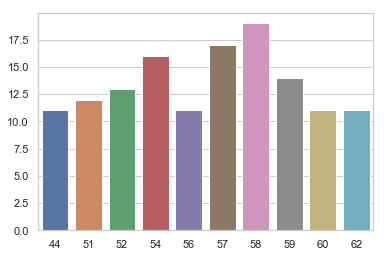

In [4]:
sns.barplot(x=ds.age.value_counts()[:10].index, y=ds.age.value_counts()[:10].values)

In [1]:
sns.pairplot(data=ds, hue='target')

NameError: name 'sns' is not defined

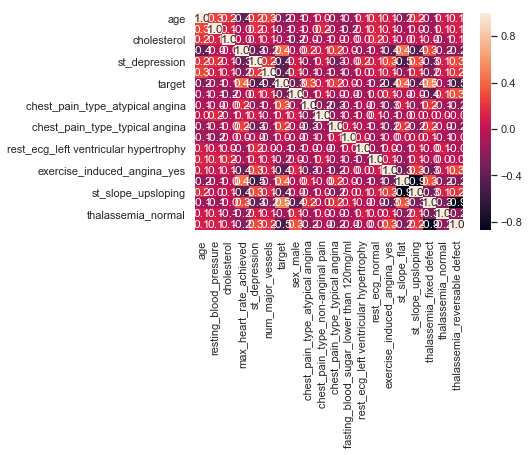

In [36]:
sns.heatmap(ds.corr(), annot=True, fmt='.1f')

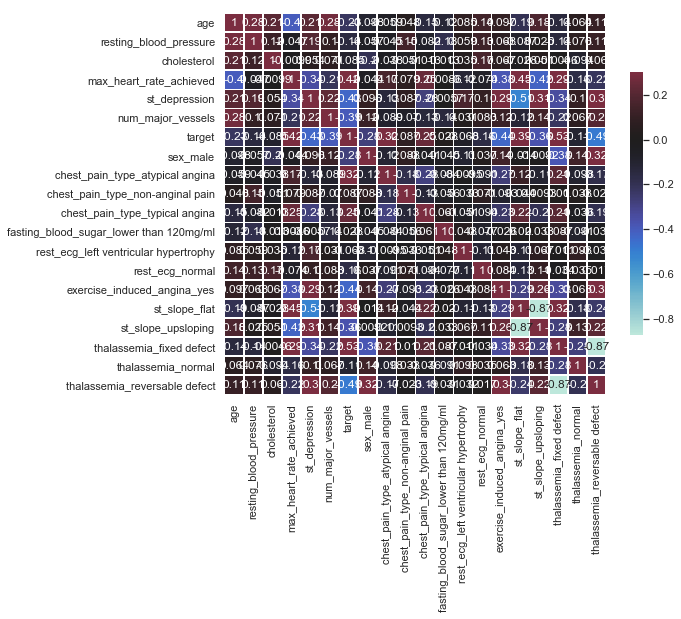

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(ds.corr(), vmax=.3, center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5}, annot=True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
for x in ['chest_pain_type', 'max_heart_rate_achieved', 'st_slope']:
    sns.relplot(x=x, y='target', data=ds, hue='sex')
plt.tight_layout()
plt.show()

In [8]:
## Categorical to Dummy

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 4] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 1] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 2] = 'flat'
ds['st_slope'][ds['st_slope'] == 3] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

# Genero le dummy features
ds = pd.get_dummies(ds, drop_first=True)

In [34]:
corr = ds.corr()
corr = corr['target']
corr.drop(index='target', inplace=True)
corr.sort_values(ascending=False, inplace=True)
#corr[corr > 0]
corr

thalassemia_fixed defect                   0.527334
max_heart_rate_achieved                    0.421741
st_slope_flat                              0.394066
chest_pain_type_atypical angina            0.316742
chest_pain_type_typical angina             0.245879
chest_pain_type_non-anginal pain           0.086957
fasting_blood_sugar_lower than 120mg/ml    0.028046
rest_ecg_left ventricular hypertrophy     -0.068410
cholesterol                               -0.085239
thalassemia_normal                        -0.106589
resting_blood_pressure                    -0.144931
rest_ecg_normal                           -0.159775
age                                       -0.225439
sex_male                                  -0.280937
st_slope_upsloping                        -0.362053
num_major_vessels                         -0.391724
st_depression                             -0.430696
exercise_induced_angina_yes               -0.436757
thalassemia_reversable defect             -0.486112
Name: target

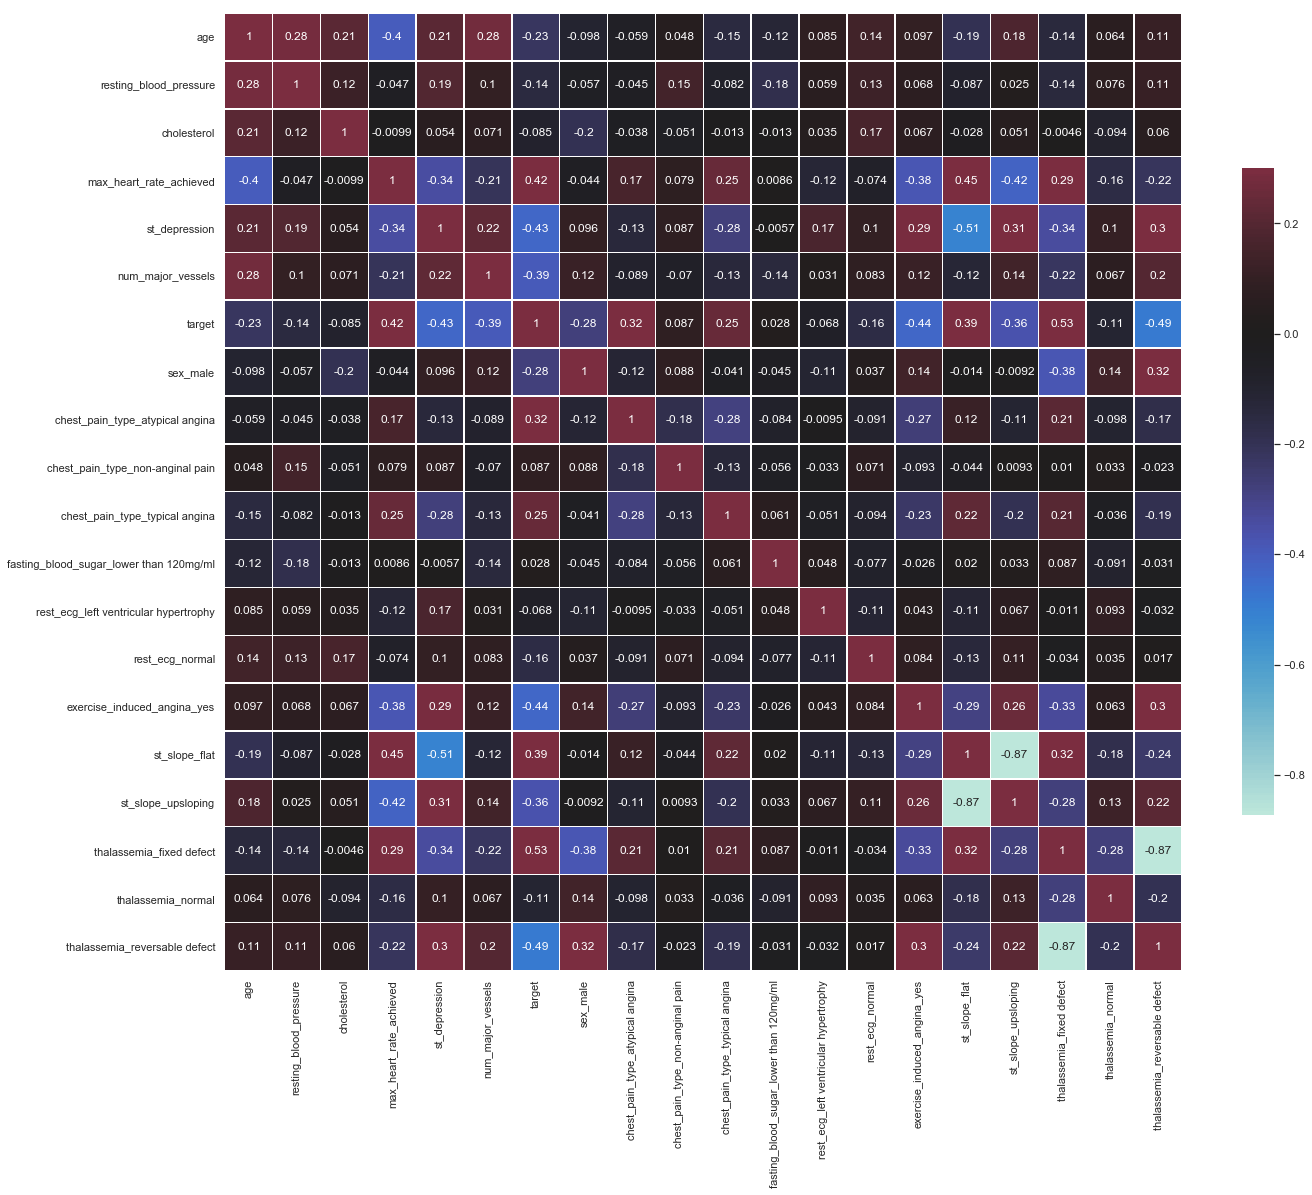

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(ds.corr(), vmax=.3, center=0, square=True, linewidth=.5, cbar_kws={'shrink': .5}, annot=True)
plt.tight_layout()
plt.show()

In [9]:
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

In [10]:
## Normalization
scaler = preprocessing.StandardScaler()
columns_names = X.columns
# Fit your data on the scaler object
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=columns_names)


C:\Users\AlessioGilardi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\AlessioGilardi\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state=0)
svm = SVC(random_state = 0, gamma='scale', kernel='linear')
svm.fit(X_train, Y_train)
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(svm.score(X_test,Y_test)*100))
Y_pred = svm.predict(X_test)

Test Accuracy of SVM Algorithm: 85.25%


('num_major_vessels', 'sex_male', 'st_depression', 'st_slope_upsloping', 'resting_blood_pressure', 'exercise_induced_angina_yes', 'fasting_blood_sugar_lower than 120mg/ml', 'rest_ecg_normal', 'cholesterol', 'st_slope_flat', 'rest_ecg_left ventricular hypertrophy', 'chest_pain_type_typical angina', 'age', 'thalassemia_normal', 'thalassemia_reversable defect', 'chest_pain_type_non-anginal pain', 'chest_pain_type_atypical angina', 'max_heart_rate_achieved', 'thalassemia_fixed defect')


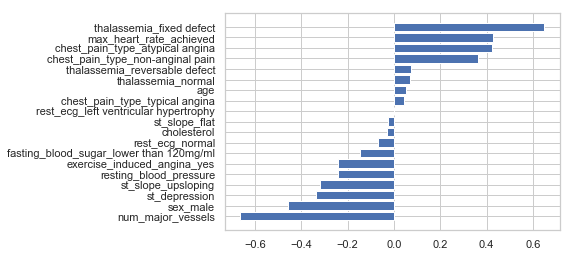

In [31]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    print(names)
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(svm.coef_.ravel(), X_test.columns)

In [42]:
corr = ds.corr()
corr = corr['target']
corr.drop(index='target', inplace=True)
corr.sort_values(ascending=False, inplace=True)
to_drop = [item for item in X.columns if item not in corr[corr > 0].index]
## Drop less important features
# to_drop = ['rest_ecg_left ventricular hypertrophy', 'st_slope_flat', 'cholesterol', 'chest_pain_type_typical angina', 'age', 'thalassemia_normal', 'rest_ecg_normal', 'thalassemia_reversable defect', 'fasting_blood_sugar_lower than 120mg/ml']
X_drop = X.drop(to_drop, axis=1)

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X_drop, Y, test_size = .2, random_state=10)
svm = SVC(random_state = 10, gamma='scale')
svm.fit(X_train, Y_train)
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(svm.score(X_test,Y_test)*100))
Y_pred = svm.predict(X_test)

Test Accuracy of SVM Algorithm: 81.97%
